STAT 479: Deep Learning (Spring 2019)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat479-ss2019/
GitHub repository: https://github.com/rasbt/stat479-deep-learning-ss19

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch,pandas,matplotlib

Sebastian Raschka 

CPython 3.7.1
IPython 7.2.0

torch 1.0.1
pandas 0.24.0
matplotlib 3.0.2


# Linear Regression with Gradient Descent

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

<br>
<br>

## Load & Prepare a Toy Dataset

In [3]:
df = pd.read_csv('./datasets/linreg-data.csv', index_col=0)
df.tail()

,x1,x2,y
995,-0.942094,-0.835856,-22.324428
996,1.222445,-0.403177,-52.121493
997,-0.112466,-1.688230,-57.043196
998,-0.403459,-0.412272,-27.701833
999,0.021351,-0.499017,-9.804714


In [4]:
# Assign features and target

X = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.float)

# Shuffling & train/test split

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent70 = int(shuffle_idx.size(0)*0.7)

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

<br>
<br>

## Implement Linear Regression Model

In [5]:
class LinearRegression1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weights), self.bias)
        activations = netinputs
        return activations.view(-1)
        
    def backward(self, x, yhat, y):  
        
        grad_loss_yhat = y - yhat
        
        grad_yhat_weights = x
        grad_yhat_bias = 1.
        
        # Chain rule: inner times outer
        grad_loss_weights = -torch.mm(grad_yhat_weights.t(),
                                      grad_loss_yhat.view(-1, 1))

        grad_loss_bias = -torch.sum(grad_yhat_bias*grad_loss_yhat)
        
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

<br>
<br>

## Define Training and Evaluation Functions

In [6]:
####################################################
##### Training and evaluation wrappers
###################################################

def loss(yhat, y):
    return torch.mean((yhat - y)**2) / y.size(0)


def train(model, x, y, num_epochs, learning_rate=0.01):
    cost = []
    for e in range(num_epochs):

        #### Compute outputs ####
        yhat = model.forward(x)

        #### Compute gradients ####
        negative_grad_w, negative_grad_b = model.backward(x, yhat, y)

        #### Update weights ####
        model.weights += learning_rate * negative_grad_w
        model.bias += learning_rate * negative_grad_b

        #### Logging ####
        yhat = model.forward(x) # not that this is a bit wasteful here
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

<br>
<br>

## Train Linear Regression Model

In [7]:
model = LinearRegression1(num_features=X_train.size(1))
cost = train(model, X_train, y_train, num_epochs=10, learning_rate=0.001)

Epoch: 001 | MSE: 0.71657
Epoch: 002 | MSE: 0.54778
Epoch: 003 | MSE: 0.53242
Epoch: 004 | MSE: 0.53101
Epoch: 005 | MSE: 0.53088
Epoch: 006 | MSE: 0.53087
Epoch: 007 | MSE: 0.53087
Epoch: 008 | MSE: 0.53087
Epoch: 009 | MSE: 0.53087
Epoch: 010 | MSE: 0.53087


<br>
<br>

## Evaluate Linear Regression Model

### Plot MSE

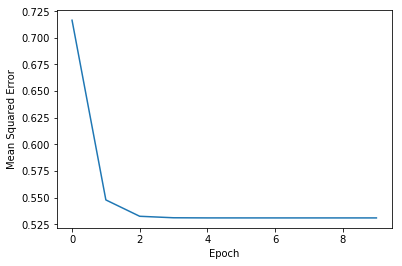

In [8]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [9]:
train_pred = model.forward(X_train)
test_pred = model.forward(X_test)

print('Train MSE: %.5f' % loss(train_pred, y_train))
print('Test MSE: %.5f' % loss(test_pred, y_test))

Train MSE: 0.53087
Test MSE: 1.35628


<br>
<br>

### Compare with analytical solution

In [10]:
print('Weights', model.weights)
print('Bias', model.bias)

Weights tensor([[ 0.3624],
        [37.8798]])
Bias tensor([-0.5464])


In [11]:
def analytical_solution(x, y):
    Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)
    w = torch.zeros(x.size(1))
    z = torch.inverse(torch.matmul(Xb.t(), Xb))
    params = torch.matmul(z, torch.matmul(Xb.t(), y))
    b, w = torch.tensor([params[0]]), params[1:].view(x.size(1), 1)
    return w, b

w, b = analytical_solution(X_train, y_train)
print('Analytical weights', w)
print('Analytical bias', b)

Analytical weights tensor([[ 0.3624],
        [37.8801]])
Analytical bias tensor([-0.5464])


<br>
<br>

## (Ungraded) HW Exercises

Modify the `train()` function such that the dataset is shuffled prior to each epoch. Do you see a difference -- Yes/No? Try to come up with an explanation for your observation.

